# **Desafío #4 – Construcción de Vista Analítica y Consultas sobre el Modelo Organizacional**

## **4.1 Introducción**

La construcción del Desafío #4 parte de las decisiones adoptadas en el Desafío #3, en el que los datos sintéticos previamente generados se migraron a un Data Lake en Azure mediante un Storage Account con capacidades de Blob Storage/ADLS Gen2. Dichos datos quedaron almacenados en un contenedor analítico (`org-raw`), organizados bajo una estructura versionada (`org_data/v1`) que refleja una capa *raw* coherente con las arquitecturas de analítica modernas.

El propósito del Desafío #4 es avanzar en este modelo, construyendo una vista analítica que permita integrar las tablas de **departamentos**, **puestos de trabajo** y **empleados**, con el fin de habilitar consultas, métricas y visualizaciones que describan el comportamiento de la organización simulada. Este enfoque permite demostrar cómo, a partir de datos alojados en un Data Lake, es posible generar un primer nivel de análisis empresarial sin requerir servicios adicionales como motores SQL administrados, Synapse o Databricks, lo cual es consistente con el contexto académico de la suscripción empleada y suficiente para los requerimientos del desafío.

El proceso se desarrolló de forma estructurada en las siguientes etapas:


## **4.2. Configuración del entorno de trabajo**

Se inicializa el entorno de ejecución cargando:

- las rutas internas del proyecto,  

- el módulo `src` donde residen los scripts desarrollados en desafíos anteriores,  

- y las variables definidas en el archivo `.env` generado durante el Desafío #3, incluyendo el connection string del Storage Account y los parámetros de la estructura del contenedor.  

Esta configuración permite acceder a los datos almacenados en la nube sin exponer credenciales en el repositorio y mantener la portabilidad entre entornos.

La celda correspondiente establece:


In [1]:
import sys
from pathlib import Path
from dotenv import load_dotenv

notebook_dir = Path.cwd()
project_root = notebook_dir.parent
src_path = project_root / "src"

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

env_path = project_root / ".env"
load_dotenv(env_path)

True

## **4.3. Lectura de los datos desde el Data Lake**

Una vez configurado el entorno, se procede a leer los archivos Parquet ubicados en el contenedor `org-raw` de Azure. Para ello se implementó una pequeña función auxiliar que, utilizando el SDK oficial `azure-storage-blob`, descarga cada archivo desde la ruta correspondiente y lo carga en memoria como un DataFrame de pandas.

Este procedimiento garantiza que:

- La lectura se realiza directamente desde la nube,  

- Se respeta la estructura de carpetas establecida en el Desafío #3,  

- Los datos están listos para el proceso de integración analítica.

La celda que materializa esta etapa es la siguiente:


In [2]:
import os
from io import BytesIO
import pandas as pd
from azure.storage.blob import BlobServiceClient

conn_str = os.getenv("AZURE_STORAGE_CONNECTION_STRING")
container_name = os.getenv("AZURE_STORAGE_CONTAINER_RAW", "org-raw")
base_prefix = os.getenv("AZURE_STORAGE_BASE_PREFIX", "org_data/v1")

blob_service = BlobServiceClient.from_connection_string(conn_str)
container_client = blob_service.get_container_client(container_name)

def load_parquet_from_datalake(prefix: str, filename: str) -> pd.DataFrame:
    blob_path = f"{base_prefix}/{prefix}/{filename}"
    blob_client = container_client.get_blob_client(blob_path)
    data_bytes = blob_client.download_blob().readall()
    return pd.read_parquet(BytesIO(data_bytes))

departments_df = load_parquet_from_datalake("departments", "departments.parquet")
job_positions_df = load_parquet_from_datalake("job_positions", "job_positions.parquet")
employees_df = load_parquet_from_datalake("employees", "employees.parquet")

departments_df.head(), job_positions_df.head(), employees_df.head()

(   department_id  department_name department_type  headcount_weight
 0              1       Operations            Core               4.0
 1              2       Commercial            Core               3.0
 2              3        IT & Data            Core               2.5
 3              4          Finance       Corporate               1.8
 4              5  Human Resources       Corporate               1.2,
    job_position_id  department_id          position_name seniority_level
 0                1              1      Operations Junior          Junior
 1                2              1  Operations SemiSenior      SemiSenior
 2                3              1      Operations Senior          Senior
 3                4              1        Operations Lead            Lead
 4                5              1     Operations Manager         Manager,
    employee_id first_name last_name  department_id  job_position_id  \
 0            1     Morgan   Ramírez              4               17

Esta etapa constituye la base del Desafío #4, pues a partir de estos tres DataFrames se desarrollarán la vista analítica integrada y las consultas derivadas.


## **4.4. Construcción de la vista analítica integrada**

Los datos almacenados en el Data Lake corresponden a tres entidades principales del modelo organizacional:

- **departments**: describe cada área funcional de la organización,  

- **job_positions**: contiene los tipos de roles definidos y su nivel jerárquico,  

- **employees**: consolida la información de cada empleado, incluyendo referencias a su departamento y al puesto que ocupa.

Para habilitar análisis posteriores, estas entidades se integran en una **vista analítica lógica**, equivalente a una tabla unificada que permite consultar las características del personal, los atributos de su cargo y la estructura departamental en un mismo espacio de análisis.

La vista se construye mediante operaciones de unión (`merge`) utilizando las claves foráneas del modelo sintético. Este enfoque permite replicar la lógica de una vista SQL, pero mantener la ejecución en un entorno de análisis directo sobre dataframes.


In [3]:
# Unir employees + job_positions
employees_positions = employees_df.merge(
    job_positions_df,
    how="left",
    left_on="job_position_id",
    right_on="job_position_id",
    suffixes=("", "_job")
)

# Unir con departments
org_view = employees_positions.merge(
    departments_df,
    how="left",
    left_on="department_id",
    right_on="department_id",
    suffixes=("", "_dept")
)

org_view.head()

,employee_id,first_name,last_name,department_id,job_position_id,seniority_level,birth_date,hire_date,age,tenure_years,salary,department_id_job,position_name,seniority_level_job,department_name,department_type,headcount_weight
0,1,Morgan,Ramírez,4,17,SemiSenior,1996-10-23,2022-09-12,29,3,5020.654146,4,Finance SemiSenior,SemiSenior,Finance,Corporate,1.8
1,2,Robin,Sánchez,2,8,Senior,1995-02-17,2024-09-03,30,1,6729.943947,2,Commercial Senior,Senior,Commercial,Core,3.0
2,3,Casey,López,5,24,Lead,1968-02-29,2024-06-16,57,1,6857.866259,5,Human Resources Lead,Lead,Human Resources,Corporate,1.2
3,4,Taylor,López,4,18,Senior,1974-03-20,2024-04-13,51,1,9485.641900,4,Finance Senior,Senior,Finance,Corporate,1.8
4,5,Taylor,Ramírez,1,5,Manager,1991-04-24,2022-02-21,34,3,5024.217107,1,Operations Manager,Manager,Operations,Core,4.0


La vista integrada `org_view` consolida la información relevante del modelo:

- datos personales y laborales del empleado,  

- nivel y categoría del puesto de trabajo,  

- departamento al que pertenece,  

- información salarial, antigüedad y edad,  

- relación entre estructura jerárquica y composición organizacional.  

A partir de esta vista es posible formular consultas y métricas típicas en un contexto de datos organizacionales, tales como distribución salarial, composición por niveles jerárquicos, tamaño de cada departamento, y análisis de estructura organizacional.

## **4.5. Métricas y consultas analíticas**

### **4.5.1. Distribución del headcount por departamento**

Una de las métricas fundamentales en la analítica de recursos humanos es el tamaño relativo de cada departamento. Esto permite entender dónde se concentra la mayor parte del personal y facilita la toma de decisiones relacionadas con el crecimiento, los presupuestos, las cargas operativas y las futuras contrataciones.

A continuación se calcula el número de empleados por departamento.

In [4]:
headcount_by_dept = (
    org_view.groupby("department_name")
            .size()
            .sort_values(ascending=False)
            .reset_index(name="headcount")
)

headcount_by_dept

,department_name,headcount
0,Operations,173
1,Commercial,127
2,IT & Data,112
3,Finance,82
4,Human Resources,46
5,Legal & Compliance,33
6,Strategy & Projects,27


El siguiente gráfico resume visualmente la composición organizacional.   
 
Los departamentos con mayor número de empleados representan áreas con una mayor demanda operativa o estratégica dentro de la organización simulada.

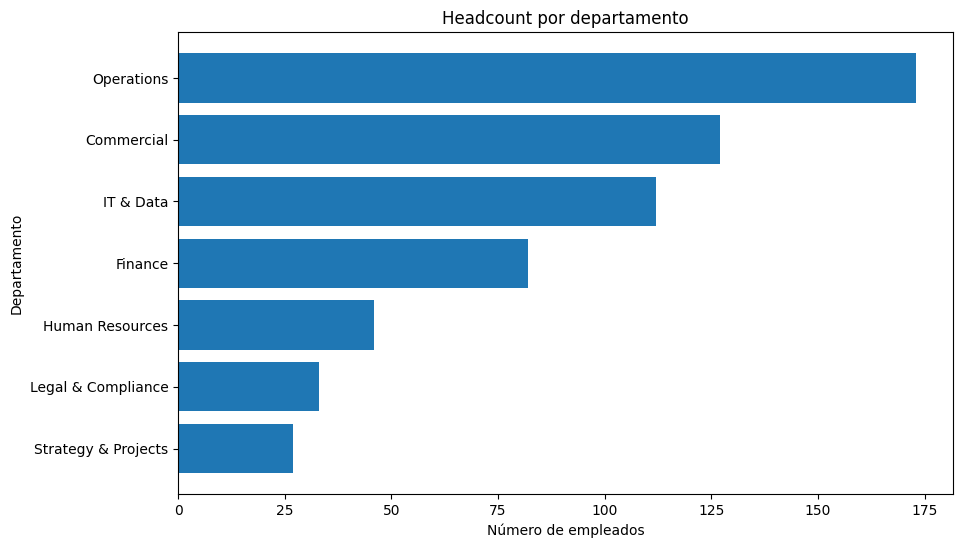

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(headcount_by_dept["department_name"], headcount_by_dept["headcount"])
plt.xlabel("Número de empleados")
plt.ylabel("Departamento")
plt.title("Headcount por departamento")
plt.gca().invert_yaxis()
plt.show()

### **4.5.2: Distribución salarial por nivel de puesto**

La estructura salarial suele reflejar la jerarquía y la complejidad de los distintos roles dentro de una organización.  
A partir del modelo sintético, se analiza la distribución de los salarios según el nivel del cargo, lo que permite validar su coherencia interna y explorar patrones de compensación.

Se calcula el salario promedio por nivel de puesto.

In [8]:
import pandas as pd

pd.options.display.float_format = "{:.2f}".format

salary_by_level = (
    org_view.groupby("seniority_level")
            .agg(
                avg_salary=("salary", "mean"),
                min_salary=("salary", "min"),
                max_salary=("salary", "max"),
                count=("salary", "size")
            )
            .round(2)   # redondeo a 2 decimales
            .reset_index()
            .sort_values("avg_salary")
)

salary_by_level



,seniority_level,avg_salary,min_salary,max_salary,count
0,Junior,4747.40,1099.27,16147.77,240
3,SemiSenior,6138.85,1611.02,15959.80,167
4,Senior,7798.88,1680.62,32449.49,116
1,Lead,8809.39,2401.64,21511.47,39
2,Manager,11777.07,3612.61,39746.24,38


El siguiente gráfico permite visualizar la progresión salarial según nivel jerárquico, observando la coherencia entre la estructura organizacional y los valores del modelo sintético.

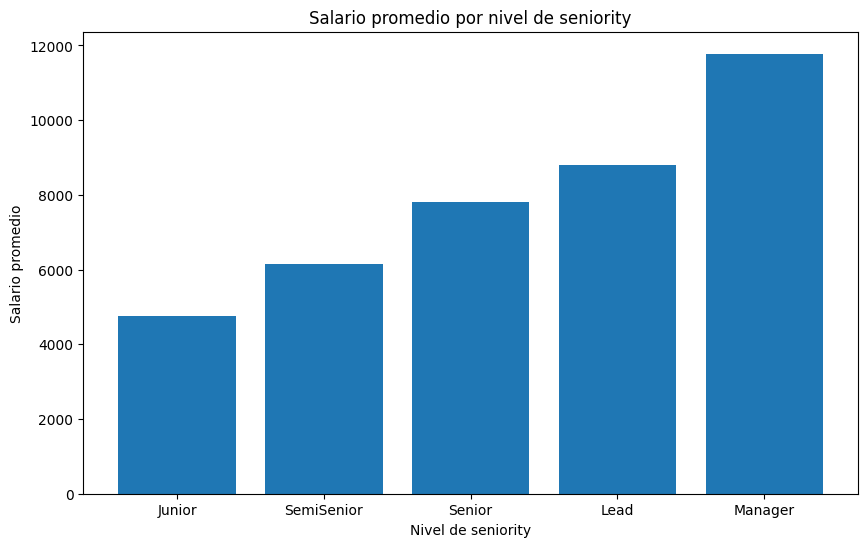

In [10]:
plt.figure(figsize=(10,6))
plt.bar(salary_by_level["seniority_level"], salary_by_level["avg_salary"])
plt.ylabel("Salario promedio")
plt.xlabel("Nivel de seniority")
plt.title("Salario promedio por nivel de seniority")
plt.show()


### **4.5.3. Relación entre antigüedad y nivel del cargo**

La antigüedad en la organización puede influir en las oportunidades de ascenso, en la distribución de roles y en la estructura jerárquica.  
 
El siguiente análisis explora cómo se distribuye la antigüedad promedio según el nivel del puesto ocupado.

Esto permite observar patrones internos del modelo, por ejemplo, si los cargos de mayor seniority tienden a presentar mayor permanencia o si existe una distribución homogénea entre niveles.


In [13]:
tenure_by_level = (
    org_view.groupby("seniority_level")
            .agg(avg_tenure=("tenure_years", "mean"))
            .round(1)  # redondeo a 1 decimal
            .reset_index()
)

tenure_by_level


,seniority_level,avg_tenure
0,Junior,2.60
1,Lead,2.60
2,Manager,2.40
3,SemiSenior,2.80
4,Senior,2.80


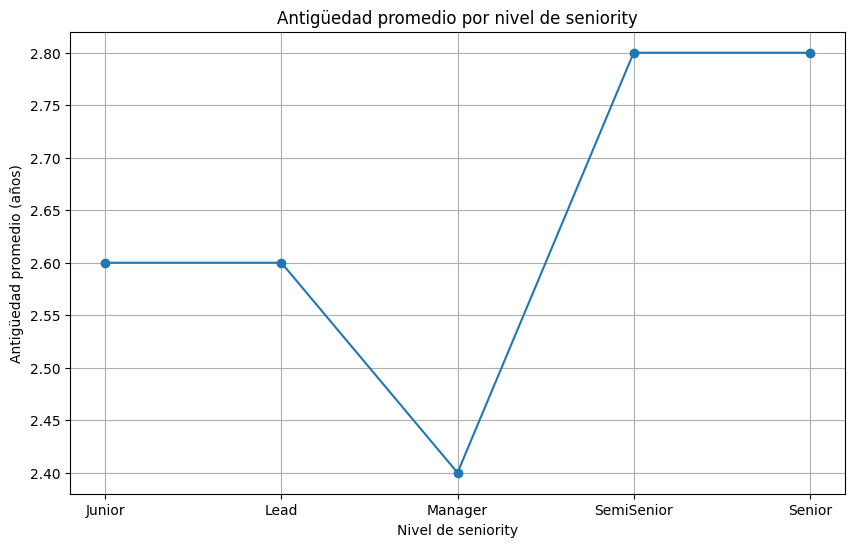

In [14]:
plt.figure(figsize=(10,6))
plt.plot(
    tenure_by_level["seniority_level"],
    tenure_by_level["avg_tenure"],
    marker="o"
)
plt.ylabel("Antigüedad promedio (años)")
plt.xlabel("Nivel de seniority")
plt.title("Antigüedad promedio por nivel de seniority")
plt.grid(True)
plt.show()


La distribución de la antigüedad promedio muestra un comportamiento estable entre los niveles **Junior** y **Lead**, con una ligera disminución en **Manager**, lo que sugiere una mayor rotación o movilidad en posiciones de coordinación intermedia. A partir de ese punto, la antigüedad aumenta en **SemiSenior** y se mantiene alta en **Senior**, un patrón coherente con estructuras organizacionales en las que los roles de mayor experiencia tienden a presentar menor rotación y una permanencia más prolongada debido a la especialización y consolidación del conocimiento institucional.


### **4.5.4 Indicadores generales de la organización**

Finalmente, se construye un pequeño conjunto de indicadores agregados que permiten obtener una vista general del comportamiento de la organización simulada.

Estos indicadores sirven como un resumen cuantitativo del modelo sintético, equivalente a un panel de métricas básico utilizado en la caracterización organizacional.


In [15]:
kpis = {
    "Total empleados": len(org_view),
    "Departamentos": org_view["department_id"].nunique(),
    "Puestos de trabajo": org_view["job_position_id"].nunique(),
    "Edad promedio": round(org_view["age"].mean(), 2),
    "Salario promedio": round(org_view["salary"].mean(), 2),
    "Antigüedad promedio (años)": round(org_view["tenure_years"].mean(), 2)
}

kpis

{'Total empleados': 600,
 'Departamentos': 7,
 'Puestos de trabajo': 35,
 'Edad promedio': np.float64(36.55),
 'Salario promedio': np.float64(6433.88),
 'Antigüedad promedio (años)': np.float64(2.66)}

### **4.5.5 Conclusión del Desafío #4**

El análisis desarrollado cumple con el objetivo del Desafío #4, construyendo una vista analítica a partir de los datos almacenados en el Data Lake y generando consultas y visualizaciones relevantes para la comprensión del modelo organizacional.

La integración de las tres entidades principales permitió:

- obtener una representación unificada del personal, sus roles y los departamentos,  

- explorar indicadores clásicos en analítica organizacional,  

- validar la coherencia estadística del modelo sintético,  

- y producir un primer conjunto de reportes que podrían servir como base para dashboards, APIs o capas de consumo posteriores.

Este flujo demuestra cómo, a partir de un Data Lake en Azure, es posible habilitar procesos analíticos completos sin requerir componentes adicionales de infraestructura, cumpliendo plenamente con los requerimientos del desafío.